In [22]:
import os
import sys
import hotspot
import anndata
import numpy as np
import pandas as pd
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import mplscience
from scipy.io import mmread
from scipy.sparse import csr_matrix, csc_matrix
import scanpy as sc
import warnings; warnings.simplefilter('ignore')
import pickle5 as pickle
import mechanicalsoup
from time import time, sleep
import re
from datetime import datetime
import json
import itertools
from random import random

In [23]:
def method_in_2_lines(method):
    return method.replace(' (', '\n(')

In [24]:
ANALYSIS_FOLDER = "../SPIRAL/static/analysis/"
def filter_struct_lst_for_result_panel(data_n, new_Jaccard_thr_genes):
    # produces a list of structures, in which there is no pair of structures with Jaccard index larger than
    # Jaccard_thr_genes. The function relies on the fact that the structure numbers are
    # range(1, len(Jaccard_mat_genes) + 1), and that structure i corresponds to row i-1 in Jaccard_mat_genes.
    print('filter_struct_lst_for_result_panel!!!')

    data_path = os.path.join(ANALYSIS_FOLDER, 'data' + str(data_n))
    # get the Jaccard matrix of gene lists
    Jaccard_mat_genes = np.load(os.path.join(data_path, 'Jaccard_mat_genes.npy'))

    inds = list(range(1, len(Jaccard_mat_genes) + 1))
    thr_struct_lst = []

    while inds:
        i = inds.pop(0)
        thr_struct_lst.append(i)
        similar_to_i = []

        for j in inds:
            if Jaccard_mat_genes[i - 1][j - 1] >= new_Jaccard_thr_genes:
                similar_to_i.append(j)

        inds = [j for j in inds if j not in similar_to_i]

    return thr_struct_lst

In [25]:
# Build dataset_dict
dataset_dict = dict(zip([1, 3, 2, 5, 4, 6], 
                        ['lymphoblastoid cell line GM12891', 
                        'Zebrafish differentiation (7 time points)',
                        'sagittal-posterior section of a mouse brain',
                        'human prostate',
                        'human differentiation (days 0 and 7 − 21)',
                        'mouse B cells, treated with anti-IgM mAb (25 time points in the 6 hours post stimulation)'
                       ]))
dataset_type = dict(zip([1, 3, 2, 5, 4, 6], 
                        ['single cell', 'single cell', 
                        'spatial', 'spatial',
                        'bulk', 'bulk'
                       ]))

dataset_dict[20] = 'Slide-seqV2- diabetic kidney mouse'
dataset_type[20] = 'spatial'

dataset_dict[21] = 'Slide-seqV2- normal kidney mouse'
dataset_type[21] = 'spatial'

for data_n in range(61, 81):
    f = open("../SPIRAL/static/analysis/data" + str(data_n) + "/dataset_name.txt", 'r')
    name = f.readlines()[0]
    #print(name)
    f.close()
    
    dataset_dict[data_n] = 'mouse ' + name.replace('__', ' ')
    dataset_type[data_n] = 'spatial'


# Build methods_dict
methods_dict = {'single cell': ['SPIRAL (Jaccard index=0.05)',
                                'SPIRAL (Jaccard index=0.5)',
                                'SPIRAL (Jaccard index=0.75)',
                                'Seurat',
                                'Slingshot+tradeSeq (nPoints=20)',
                                'Slingshot+tradeSeq (nPoints=200)',
                                "Hotspot (n_neighbors=30)",
                                "Hotspot (n_neighbors=300)",
                                'nsNMF',
                                'SingleCellHaystack (k=3)',
                                'SingleCellHaystack (k=5)'],
               'spatial':  ['SPIRAL (Jaccard index=0.05)',
                            'SPIRAL (Jaccard index=0.5)',
                            'SPIRAL (Jaccard index=0.75)',
                            'Seurat',
                            "Hotspot (n_neighbors=30)",
                            "Hotspot (n_neighbors=300)",
                            'nsNMF',
                            'SpatialDE (C=3)',
                            'SpatialDE (C=5)',
                            'SingleCellHaystack (k=3)',
                            'SingleCellHaystack (k=5)'],
               'bulk': ['SPIRAL (Jaccard index=0.05)',
                        'SPIRAL (Jaccard index=0.5)',
                        'SPIRAL (Jaccard index=0.75)',
                        'Seurat',
                        'nsNMF']}


In [26]:
out_folder = "../SPIRAL_for_paper_/comparison_of_all_methods_real_datasets/module_sizes/"
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [43]:
module_sizes = dict()
data_n = 5
dataset = dataset_dict[data_n]
typee = dataset_type[data_n]
methods = methods_dict[typee]

print(dataset)
for method in methods:
    print(dataset, typee, method)
    
    data_path = "../SPIRAL/static/analysis/data" + str(data_n)
    species = open(os.path.join(data_path, 'species.txt'), "r").read()
    impute_method = open(os.path.join(data_path, 'imputation_method.txt'), "r").read()

    #get genelist for this dataset
    #genelist_file = os.path.join(data_path, impute_method + '_genetable.p')
    # Load genes_table
    #with open(genelist_file, 'rb') as fp:
    #    genes_table = pickle.load(fp)
    #background_list = str(list(genes_table.index)).replace("'", "").replace('[', '').replace(']', '').replace(', ','\n')

    flag = False
    if method == 'nsNMF':
        method_folder = 'nsNMF/data' + str(data_n) + '/'
        name_clus2 = 'module'
        for file in os.listdir(method_folder):
            if file.startswith("cluster_table"):
                #print(file)
                method_cluster_table_file = os.path.join(method_folder, file)
                flag = True
    elif method == 'Seurat':
        method_folder = 'Seurat_DE_genes/data' + str(data_n) + '/'
        name_clus2 = 'DE gene set'
        for file in os.listdir(method_folder):
            if file.startswith("cluster_table"):
                #print(file)
                method_cluster_table_file = os.path.join(method_folder, file)
                flag = True
    elif method in ['Slingshot+tradeSeq (nPoints=20)', 'Slingshot+tradeSeq (nPoints=200)']:
        method_folder = 'Slingshot/data' + str(data_n) + '/'
        name_clus2 = 'gene cluster'
        if method == 'Slingshot+tradeSeq (nPoints=20)':
            file = 'cluster_table_20.csv'
            method_cluster_table_file = os.path.join(method_folder, file)
            flag = True
        elif method == 'Slingshot+tradeSeq (nPoints=200)':
            file = 'cluster_table_200.csv'
            method_cluster_table_file = os.path.join(method_folder, file)
            flag = True
    elif 'Hotspot' in method:
        if data_n == 3:
            flag = False
        else:
            method_folder = 'Hotspot/data' + str(data_n) + '/'
            name_clus2 = 'gene module'
            if method == "Hotspot (n_neighbors=30)":
                file = 'cluster_table_danb_30.csv'     
            elif method == "Hotspot (n_neighbors=300)":
                file = 'cluster_table_danb_300.csv'
            method_cluster_table_file = os.path.join(method_folder, file)
            flag = True
    elif 'SpatialDE' in method:
        method_folder = 'SpatialDE/data' + str(data_n) + '/'
        name_clus2 = 'pattern'
        if method=='SpatialDE (C=3)':
            file = 'cluster_table_3.csv'
        elif method=='SpatialDE (C=5)':
            file = 'cluster_table_5.csv'
        method_cluster_table_file = os.path.join(method_folder, file)
        flag = True
    elif 'SingleCellHaystack' in method:
        method_folder = 'singlecellhaystack/data' + str(data_n) + '/'
        name_clus2 = 'cluster'
        if method=='SingleCellHaystack (k=3)':
            file = 'data' + str(data_n) + '.singleCellHaystack.k_3.csv'
        elif method=='SingleCellHaystack (k=5)':
            file = 'data' + str(data_n) + '.singleCellHaystack.k_5.csv'
        method_cluster_table_file = os.path.join(method_folder, file)
        flag = True


    if flag:
        method_cluster_table = pd.read_csv(method_cluster_table_file, index_col=0)

        if method in ['Seurat', 'Slingshot+tradeSeq (nPoints=20)', 'Slingshot+tradeSeq (nPoints=200)']:
            method_cluster_table.loc[:, 'genes'] = [
                str(genes.replace("['", "").replace("']", "").split(", ")) for genes in method_cluster_table.loc[:, 'genes']]
        elif 'SingleCellHaystack' in method:
            method_cluster_table = pd.read_csv(method_cluster_table_file)
            method_cluster_table.columns = ['#genes', 'genes']
            method_cluster_table.loc[:, 'genes'] = [
                str(a.split(' ')) for a in method_cluster_table.loc[:, 'genes']]
        print('\n\n', method, method_cluster_table_file)

    elif method in ['SPIRAL (Jaccard index=0.05)', 
                    'SPIRAL (Jaccard index=0.5)', 
                    'SPIRAL (Jaccard index=0.75)']:
        flag = True

        struct_table_file = os.path.join(data_path, impute_method + '_sigtable_filt_GO_vis.xlsx')

        struct_table = pd.read_excel(struct_table_file, index_col=0)

        if method=='SPIRAL (Jaccard index=0.05)':
            struct_list = filter_struct_lst_for_result_panel(data_n=data_n, 
                                                             new_Jaccard_thr_genes=0.05)
            struct_list_str = str(struct_list)

        elif method=='SPIRAL (Jaccard index=0.5)':
            struct_list = filter_struct_lst_for_result_panel(data_n=data_n, 
                                                             new_Jaccard_thr_genes=0.5)
            struct_list_str = str(struct_list) 

        elif method=='SPIRAL (Jaccard index=0.75)':
            struct_list = filter_struct_lst_for_result_panel(data_n=data_n, 
                                                             new_Jaccard_thr_genes=0.75)
            struct_list_str = str(struct_list) 

        method_cluster_table = struct_table.loc[struct_list, ['num_genes_in_struct', 'genes']].rename(columns={'num_genes_in_struct': '#genes'})
        method_cluster_table.loc[:, 'genes'] = [str(a.split(',')) for a in method_cluster_table.loc[:, 'genes']]

    if not flag:
        print('\n\n', dataset, '+', method, flag, '!!!!!!!!!!!\n\n')
    if flag:
        print(dataset, '+', method, '\n', method_cluster_table.head())

        #module_GO_terms[dataset][method] = dict()
        GO_terms = dict()

        cluster_table = method_cluster_table
        if method == "nsNMF" and (data_n in range(20, 81)):
            module_size_list = list(cluster_table["#genes"])
        else:
            module_size_list = []
            for clus_ind, clus in enumerate(cluster_table.index):
                # read cluster gene list
                geneslist = cluster_table.loc[clus, 'genes'].replace("['", "").replace("']", "").split("', '")
                module_size_list.append(len(geneslist))
        
        module_sizes[method] = module_size_list


human prostate
human prostate spatial SPIRAL (Jaccard index=0.05)
filter_struct_lst_for_result_panel!!!
human prostate + SPIRAL (Jaccard index=0.05) 
     #genes                                              genes
1       64  ['ACTA2', 'ACTB', 'ACTG2', 'ACTN1', 'ADRA1A', ...
2      206  ['ABCC4', 'ABHD2', 'ACACA', 'ACADL', 'ACADVL',...
5       77  ['AEBP1', 'BMPER', 'C1R', 'C1S', 'CAMK2N1', 'C...
21     159  ['ABCB1', 'ABCG2', 'ACKR1', 'ADAMTS9', 'ADAMTS...
24     196  ['A2M', 'ACAP1', 'ADAMTS10', 'ADAMTSL2', 'ADGR...
human prostate spatial SPIRAL (Jaccard index=0.5)
filter_struct_lst_for_result_panel!!!
human prostate + SPIRAL (Jaccard index=0.5) 
    #genes                                              genes
1      64  ['ACTA2', 'ACTB', 'ACTG2', 'ACTN1', 'ADRA1A', ...
2     206  ['ABCC4', 'ABHD2', 'ACACA', 'ACADL', 'ACADVL',...
3     197  ['ABCC3', 'ABCC4', 'ABHD2', 'ACSM3', 'ACVR1B',...
4     177  ['ACTA2', 'ACTB', 'ACTG2', 'ACTN1', 'ADAM33', ...
5      77  ['AEBP1', 'BMPER', 'C1R', '

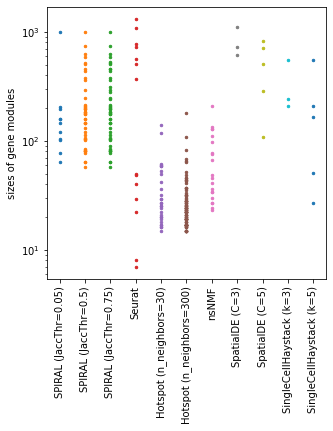

In [44]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
for method in module_sizes.keys():
    if "SPIRAL" not in method:
        #plt.scatter([method_in_2_lines(method)]*len(module_sizes[method]), module_sizes[method])
        plt.scatter([method]*len(module_sizes[method]), module_sizes[method], s=6)
    else:
        plt.scatter([method.replace("Jaccard index", "JaccThr")]*len(module_sizes[method]), module_sizes[method], s=6)
ax.set_yscale('log')
plt.xticks(rotation=90)
#plt.xlabel('method')
plt.ylabel('sizes of gene modules')
#plt.show()
plt.savefig(os.path.join(out_folder, dataset.replace(" ", "_").replace("(", "").replace(")", "") + '_module_sizes.jpg'), 
            bbox_inches = "tight")
plt.savefig(os.path.join(out_folder, dataset.replace(" ", "_").replace("(", "").replace(")", "") + '_module_sizes.eps'), 
            bbox_inches = "tight", format='eps')